# Project Motivation
With the rise of telederm, users upload a photo of their face to aid dermatologists in the assessment. They then count and determine the type of every acne. However, this process is labour intensive, prone to bias and does not scale well. Hence, being able to identify the type of acne found on the face using computer vision, this creates room for automated acne diagnosis. Alternatively, in recommendation systems for skincare products on ecommerce sites, this data can empower the algorithms behind by acting as an additional source of information to recommend specific products which would be ideal to remedy the acne.

# Project Description
Using our learning model, users can take a photo of themselves and upload it. We will then segment the photo into windows and let the model classify the type of acne. With the output classification, we will then determine the count of every acne type on users’ faces. This will then provide the dermatologist with data to determine the best course of action for the user.

# Steps

## 1. Data Scraping
For our dataset, we will be scraping acne images from https://dermnetnz.org/. This section loops through `img` tag of the gallery using BeautifulSoup library and downloads them.

In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import shutil

def download_image(image_url, image_name):
    url = image_url
    response = requests.get(url, stream=True)
    with open(image_name, 'wb') as out_file:
        shutil.copyfileobj(response.raw, out_file)
    del response

In [40]:
def scrape_dermnet(url):
    html_page = requests.get(url)
    soup = BeautifulSoup(html_page.content, 'html.parser')
    textBlock = soup.find('section', class_="textBlock")
    imgs = textBlock.findAll('img')
    img_dataset = pd.DataFrame([[img.attrs['alt'], "https://dermnetnz.org/" + img.attrs['data-src']] for img in imgs], columns=['alt', 'image_url'])
    img_dataset['image_name'] = [f'data/image_{e}.jpg' for e in range(img_dataset.shape[0])]
    return img_dataset

In [6]:
# Download images
img_dataset = scrape_dermnet("https://dermnetnz.org/topics/acne-face-images")
for row in img_dataset.itertuples():
    download_image(row.image_url, row.image_name)

253 images were successfully scraped.

## 1.1 Sliding Window

As each facial image may contain multiple acne of different acne types, it will be best to break it into smaller patches to aid with the counting. We will construct a sliding window of size 50 x 50 and stride 50, iterating across each image to generate patches.

In [2]:
from os import listdir, rename
from os.path import isfile, join
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import random

In [38]:
images = [join('scraped_data', f) for f in listdir('scraped_data') if isfile(join('scraped_data', f))]

In [39]:
# Set size of sliding window
window_size = 50

In [68]:
# Slicing images
counter = 0
for image_path in images:
    img = np.asarray(Image.open(image_path))
    for i in range(0,img.shape[0],window_size):
        for j in range(0,img.shape[1],window_size):
            sub_img = img[i:i+window_size, j:j+window_size, :]
            # Save image
            img_name = image_path.split('/')[-1].split('.')[0]
            Image.fromarray(sub_img).save(f'temp_dataset/{counter}.jpg')
            counter += 1

In [81]:
# Create csv for tagging
cropped_images = sorted([f for f in listdir('temp_dataset') if isfile(join('temp_dataset', f))])
shuffled_images_name = cropped_images.copy()
random.shuffle(shuffled_images_name)
filenames_rows = list(zip(cropped_images, shuffled_images_name))

In [82]:
tagging_df = pd.DataFrame(filenames_rows, columns=['Image File', 'New Image Name'])

In [87]:
# Rename files with shuffled names
for idx, row in tagging_df.iterrows():
    rename(f'temp_dataset/{row["Image File"]}', f'dataset/{row["New Image Name"]}')

In [83]:
tagging_df.head()

,Image File,New Image Name
0,0.jpg,2193.jpg
1,1.jpg,4976.jpg
2,10.jpg,2599.jpg
3,100.jpg,6201.jpg
4,1000.jpg,1952.jpg


In [ ]:
tagging_df.to_csv('original_filename.csv', index=False)

Through this process, we generated approximately 7,500 patches. We then manually labelled 1,500 patches as our dataset to split into train and test later on. These patches were labelled as one of these 6 classes:
- Not face - 0
- Normal skin - 1
- Pustule - 2
- Whitehead - 3
- Blackhead - 4
- Cyst - 5


## Modelling

In [1]:
from os import listdir, rename
from os.path import isfile, join
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from collections import Counter
from skimage.transform import rotate, AffineTransform, warp
from skimage.util import random_noise

In [2]:
# !pip3 install scikit-image

In [3]:
labels = pd.read_csv('labels.csv')

In [4]:
labels.head()

,filename,label
0,0.jpg,1
1,1.jpg,1
2,2.jpg,5
3,3.jpg,1
4,4.jpg,1


In [5]:
labels.shape

(1664, 2)

### Helper Functions

In [6]:
def load_images(labels):
    X = []
    y = []
    for row in labels.itertuples():
        img_path = join('dataset', row.filename)
        img = np.asarray(Image.open(img_path))
        
        # Keep squares for now
        if img.shape[0] == img.shape[1]:
            y.append(row.label)
            X.append(img)
    return X, y


In [7]:
def augment_data(X_train, y_train):
    final_X_train = []
    final_y_train = []
    for i in range(len(X_train)):
        final_X_train.append(X_train[i])
        final_X_train.append(rotate(X_train[i], angle=45, mode = 'wrap'))
        final_X_train.append(np.fliplr(X_train[i]))
        final_X_train.append(np.flipud(X_train[i]))
        final_X_train.append(random_noise(X_train[i],var=0.2**2))
        
        final_y_train += [y_train[i]] * 5
    return final_X_train, final_y_train

In [8]:
def get_accuracy(scores, labels):
    num_data = scores.size(0)
    predicted_labels = scores.argmax(dim=1)
    indicator = (predicted_labels == labels)
    num_matches = indicator.sum()
    return 100*num_matches.float()/num_data  

def get_error( scores , labels ):

    bs=scores.size(0)
    predicted_labels = scores.argmax(dim=1)
    indicator = (predicted_labels == labels)
    num_matches=indicator.sum()
    
    return 1-num_matches.float()/bs   

def eval_on_test_set(test_data, test_label, net, mean, std, bs):

    running_error=0
    running_acc = 0
    num_batches=0

    for i in range(0,500,bs):

        minibatch_data =  test_data[i:i+bs]
        minibatch_label = test_label[i:i+bs]
        
        inputs = (minibatch_data - mean)/std

        scores= net( inputs ) 

        error = get_error( scores.detach() , minibatch_label)
        acc = get_accuracy( scores.detach() , minibatch_label)

        running_error += error.item()
        running_acc += acc.item()

        num_batches+=1

    total_error = running_error/num_batches
    total_acc = running_acc/num_batches
    print(running_error, num_batches)
    print( 'error rate on test set =', total_error*100 ,'percent')
    print('accuracy =', total_acc)

In [95]:
def augment_data(X_train, y_train):
    final_X_train = []
    final_y_train = []
    label_distribution = Counter(y_train)
    plt.bar(label_distribution.keys(), label_distribution.values())
    plt.show()
    print(label_distribution)
    max_count_label = max(label_distribution, key=label_distribution.get)
    min_count_label = min(label_distribution, key=label_distribution.get)
    for i in range(len(X_train)):
        label_key = y_train[i]
        if label_distribution[max_count_label] - label_distribution[label_key] >= 10 or label_distribution[max_count_label] - label_distribution[min_count_label] <= 6:
            final_X_train.append(X_train[i])
            angle = 90
            while angle < 360:
                final_X_train.append(rotate(X_train[i], angle=angle, mode = 'wrap'))
                angle+=90
            
            final_X_train.append(random_noise(X_train[i],var=0.05**2))
        
            final_y_train += [y_train[i]] * 5
            label_distribution = Counter(final_y_train)
            max_count = max(label_distribution, key=label_distribution.get)
            min_count = min(label_distribution, key=label_distribution.get)
    print(label_distribution)
    plt.bar(label_distribution.keys(), label_distribution.values())
    plt.show()
    return final_X_train, final_y_train

In [9]:
X, y = load_images(labels)

In [10]:
Counter(y)

Counter({5: 156, 1: 309, 2: 224, 3: 169, 4: 157, 0: 135})

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 13, stratify=y)

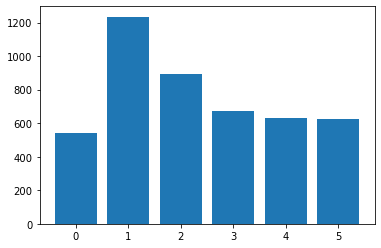

Counter({1: 1235, 2: 895, 3: 675, 4: 630, 5: 625, 0: 540})
Counter({2: 2855, 4: 2730, 3: 2705, 0: 2700, 5: 2680, 1: 2660})


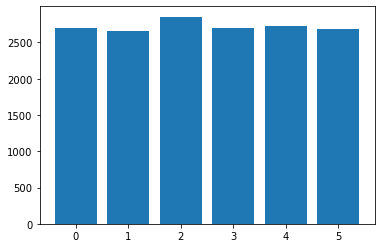

In [96]:
X_train, y_train = augment_data(X_train, y_train)

### Training

In [97]:
import torch

In [98]:
class convnet(torch.nn.Module):

    def __init__(self, input_channel, hidden_layer, num_class):

        super(convnet, self).__init__()
      
        self.conv1a = torch.nn.Conv2d(input_channel, hidden_layer,  kernel_size=5, padding=1 )
        self.pool1a  = torch.nn.MaxPool2d(2,2)
        self.conv1b = torch.nn.Conv2d(hidden_layer,  hidden_layer,  kernel_size=5, padding=1 )
        self.pool1b  = torch.nn.MaxPool2d(2,2)
        
        self.linear1 = torch.nn.Linear(12100, num_class)

    def forward(self, x):
        x = self.conv1a(x)
        x = torch.nn.functional.relu(x)
        x = self.pool1a(x)
        x = self.conv1b(x)
        x = torch.nn.functional.relu(x)
        x = self.pool1b(x)
        
        x = x.view(-1, 12100)
        x = self.linear1(x)
        
        return x

In [102]:
def train_network(X_train, y_train, X_test, y_test):
    X_train = torch.from_numpy(np.array(X_train).astype(np.float32))
    y_train = torch.from_numpy(np.array(y_train).astype(np.float32)).type(torch.LongTensor)
    X_test = torch.from_numpy(np.array(X_test).astype(np.float32))
    y_test = torch.from_numpy(np.array(y_test).astype(np.float32)).type(torch.LongTensor)
    X_train = X_train.view(-1, 3, 50, 50)
    X_test = X_test.view(-1, 3, 50, 50)
    
    my_lr = 0.001
    criterion = torch.nn.CrossEntropyLoss()
    bs = 128
    num_class = 6

    net = convnet(3, 100, num_class)
    mean = X_train.mean()
    std = X_train.std()
    num_train_data = X_train.size()[0]
    
    for epoch in range(2):
        # create a new optimizer at the beginning of each epoch: give the current learning rate.   
        optimizer=torch.optim.Adam( net.parameters() , lr=my_lr )

        # set the running quatities to zero at the beginning of the epoch
        running_loss=0
        running_error=0
        running_acc = 0
        num_batches=0

        # set the order in which to visit the image from the training set
        shuffled_indices = torch.randperm(num_train_data)

        for count in range(0,num_train_data,bs):

            # Set the gradients to zeros
            optimizer.zero_grad()

            # create a minibatch       
            indices = shuffled_indices[count:count+bs]
            minibatch_data =  X_train[indices]
            minibatch_label =  y_train[indices]


            # normalize the minibatch (this is the only difference compared to before!)
            inputs = (minibatch_data - mean)/std

            # tell Pytorch to start tracking all operations that will be done on "inputs"
            inputs.requires_grad_()

            # forward the minibatch through the net 
            scores=net( inputs ) 

            # Compute the average of the losses of the data points in the minibatch
            loss =  criterion( scores , minibatch_label) 

            # backward pass to compute dL/dU, dL/dV and dL/dW   
            loss.backward()

            # do one step of stochastic gradient descent: U=U-lr(dL/dU), V=V-lr(dL/dU), ...
            optimizer.step()


            # START COMPUTING STATS

            # add the loss of this batch to the running loss
            running_loss += loss.detach().item()

            # compute the error made on this batch and add it to the running error       
            error = get_error( scores.detach() , minibatch_label)
            acc = get_accuracy(scores.detach() , minibatch_label)
            running_error += error.item()
            running_acc += acc.item()

            num_batches+=1        


        # compute stats for the full training set
        total_loss = running_loss/num_batches
        total_error = running_error/num_batches
        total_acc = running_acc/num_batches


        print('epoch=',epoch, '\t loss=', total_loss , '\t error=', total_error*100 ,'percent')
        print('accuracy =', total_acc)
        print(' ')

    eval_on_test_set(X_test, y_test, net, mean, std, bs)
    return net, mean, std


In [103]:
model, mean, std = train_network(X_train, y_train, X_test, y_test)

epoch= 0 	 loss= 1.807276802137494 	 error= 82.66964475624263 percent
accuracy = 17.330355256795883
 
epoch= 1 	 loss= 1.7822381611913443 	 error= 82.54097602330148 percent
accuracy = 17.459023967385292
 
nan 4
error rate on test set = nan percent
accuracy = nan


In [17]:
from sklearn.metrics import confusion_matrix
from collections import Counter

In [104]:
test_df_X = pd.read_csv('df_X_test.csv')

In [105]:
test_X = test_df_X.values.tolist()

In [106]:
test_y = np.asarray(pd.read_csv('df_y_test.csv')).squeeze(1)

In [107]:
test_input = torch.from_numpy(np.array(test_X).astype(np.float32)).view(-1, 3, 50, 50)
test_input = (test_input - mean) / std

In [107]:
scores=model(test_input) 

In [109]:
def compute_acc_and_conf_mat(scores, actual_labels):
    y_pred = scores.detach().numpy()
    y_pred = np.argmax(y_pred, axis=1)
    indicator = (y_pred == actual_labels)
    num_matches = indicator.sum()
    acc = 100*num_matches/len(y_pred)
    conf_mat = confusion_matrix(actual_labels, y_pred)
    return acc, conf_mat

In [110]:
acc, conf_mat = compute_acc_and_conf_mat(scores, test_y)

In [111]:
pd.DataFrame(conf_mat, columns=range(0,6))

,0,1,2,3,4,5
0,16,0,43,0,0,0
1,15,0,70,0,0,0
2,21,0,52,0,0,0
3,8,0,61,0,0,0
4,8,0,51,0,0,0
5,6,0,39,0,0,0


In [112]:
acc

17.435897435897434